In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="k,l,m"

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import SimpleITK as sitk
import tensorflow
from sklearn.model_selection import train_test_split
import cv2
import random

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

workflow:

1st: 
refresh how where they

images, organizer in library, set them
make sure they are in the correct format with the segmentation labels and the images themselves

2nd: poerme con el tema de u-net y tensorflow

u-net with dropout layers para conseguir uncertainty. what do you think?

In [3]:
def myshow(img):
    nda = sitk.GetArrayViewFromImage(img)
    plt.imshow(nda)

In [4]:

img_t1 = sitk.ReadImage("..\\data\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_t1.nii.gz")
img_t1ce = sitk.ReadImage("..\\data\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_t1ce.nii.gz")
img_t2 = sitk.ReadImage("..\\data\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_t2.nii.gz")
img_flair = sitk.ReadImage("..\\data\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_flair.nii.gz")
img_seg = sitk.ReadImage("..\\data\\MICCAI_BraTS2020_TrainingData\\BraTS20_Training_001\\BraTS20_Training_001_seg.nii.gz")

"""
img_t1 = sitk.Cast(img_t1,sitk.sitkFloat32) #to ceonvert png to sitk
img_t1ce = sitk.Cast(img_t1ce,sitk.sitkFloat32) #to ceonvert png to sitk
img_t2 = sitk.Cast(img,sitk_t2.sitkFloat32) #to ceonvert png to sitk
img_flair = sitk.Cast(img_flair,sitk.sitkFloat32) #to ceonvert png to sitk
img_seg = sitk.Cast(img_seg,sitk.sitkFloat32) #to ceonvert png to sitk

print(img.GetSize())
print(img.GetOrigin()) # the top left corner usually
print(img.GetSpacing()) #physical size of each pixel
print(img.GetDirection()) #3D matrix
print(img.GetNumberOfComponentsPerPixel()) #number of channels in one pixel
"""

width = img_t1.GetWidth()
height = img_t1.GetHeight()
depth = img_t1.GetDepth()

nda_t1 = sitk.GetArrayViewFromImage(img_t1)
nda_t1ce = sitk.GetArrayViewFromImage(img_t1ce)
nda_t2 = sitk.GetArrayViewFromImage(img_t2)
nda_flair = sitk.GetArrayViewFromImage(img_flair)
nda_seg = sitk.GetArrayViewFromImage(img_seg)

(-0.5, 239.5, 239.5, -0.5)

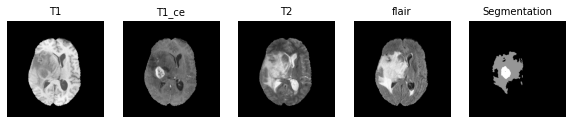

In [5]:
npa_zslice_t1 = sitk.GetArrayViewFromImage(img_t1)[int(depth/2),:,:]
npa_zslice_t1ce = sitk.GetArrayViewFromImage(img_t1ce)[int(depth/2),:,:]
npa_zslice_t2 = sitk.GetArrayViewFromImage(img_t2)[int(depth/2),:,:]
npa_zslice_flair = sitk.GetArrayViewFromImage(img_flair)[int(depth/2),:,:]
npa_zslice_seg = sitk.GetArrayViewFromImage(img_seg)[int(depth/2),:,:]

fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,5,1)
plt.imshow(npa_zslice_t1, cmap=plt.cm.Greys_r)
plt.title('T1', fontsize=10)
plt.axis('off')

fig.add_subplot(1,5,2)
plt.imshow(npa_zslice_t1ce, cmap=plt.cm.Greys_r)
plt.title('T1_ce', fontsize=10)
plt.axis('off')

fig.add_subplot(1,5,3)
plt.imshow(npa_zslice_t2, cmap=plt.cm.Greys_r)
plt.title('T2', fontsize=10)
plt.axis('off')

fig.add_subplot(1,5,4)
plt.imshow(npa_zslice_flair, cmap=plt.cm.Greys_r)
plt.title('flair', fontsize=10)
plt.axis('off')

fig.add_subplot(1,5,5)
plt.imshow(npa_zslice_seg, cmap=plt.cm.Greys_r)
plt.title('Segmentation', fontsize=10)
plt.axis('off')

In [6]:
ImgDir = "..\\data\\MICCAI_BraTS2020_TrainingData"
features_path = list()
labels_path = list()
count = 0

for folder in os.listdir(ImgDir):
    count += 1
    if 'Training' in folder and count < 10:
        new_dir = f"{ImgDir}\\{folder}"
        data = os.listdir(new_dir)
        for files in data:
            if 'flair' in files:
                features_path.append(new_dir +"\\"+ files)
            if 'seg' in files:
                labels_path.append(new_dir +"\\"+ files)

print(len(features_path))
print(len(labels_path))

X=features_path
y=labels_path

9
9


In [ ]:
len(X)
len(y)

In [ ]:
X

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1)

In [8]:
def keras_generator_train_val_test(batch_size, choice="train"):

    if choice == "train":
        X = X_train
        y = y_train
    elif choice == "val":
        X = X_val
        y = y_val
    else:
        print("Invalid Option")
        return False
    
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            rand = random.choice(range(len(X)))
            #y_rand = x_rand[:-5]+"y.jpg"
            
            x_path = X[rand]
            y_path = y[rand]
            
            print(x_path)
            print(y_path)

            x = sitk.GetArrayViewFromImage(sitk.ReadImage(x_path)) / 255.
            y = sitk.GetArrayViewFromImage(sitk.ReadImage(y_path)) / 255.
            
            x_batch.append(x)
            y_batch.append(y)

        x_batch = np.array(x_batch)
        # y_batch = np.array(y_batch)

        y_batch = {'seg': np.array(y_batch),
                #    'cls': np.array(classification_list)
                }

        yield x_batch, y_batch
"""
for x, y in keras_generator_train_val_test(2, choice="train"):
    print(x.shape, y['seg'].shape)
    break
    
print(x.shape, y['seg'].shape)
"""


'\nfor x, y in keras_generator_train_val_test(2, choice="train"):\n    print(x.shape, y[\'seg\'].shape)\n    break\n    \nprint(x.shape, y[\'seg\'].shape)\n'

In [ ]:
for i in range(16):
    random_shit = random.choice(np.arange(20))
    print(random_shit)

change the 

In [ ]:
X = list()
y = list()

for path in features_path:
    nda_img = sitk.GetArrayViewFromImage(sitk.ReadImage(path)) / 255.
    X.append(nda_img)

In [ ]:
for path in labels_path:
    nda_img = sitk.GetArrayViewFromImage(sitk.ReadImage(path)) / 255.
    y.append(nda_img)
    
X = np.array(X)
y = np.array(y)

In [ ]:
IMG_HEIGHT = width
IMG_WIDTH = height
epochs = 50
batch_size = 2

In [ ]:
def get_model():
    in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 155 ))

    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.5)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.5)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.5)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.5)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.5)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = Dropout(0.5)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = Conv2D(155, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])

    losses = {'seg': 'binary_crossentropy'
            }

    metrics = {'seg': ['acc']
                }
    model.compile(optimizer="adam", loss = losses, metrics=metrics)

    return model

In [ ]:
import datetime

class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, epoch, logs={}):

        res_dir = "intermediate_results_black_background"

        try:
            os.makedirs(res_dir)
        except:
            print(f"{res_dir} directory already exist")

        print('Training: epoch {} begins at {}'.format(epoch, datetime.datetime.now().time()))

    def on_epoch_end(self, epoch, logs=None):
        res_dir = "intermediate_results_black_background/"
        print('Training: epoch {} ends at {}'.format(epoch, datetime.datetime.now().time()))
        
        for x_test, y_test in keras_generator_train_val_test(batch_size, choice="test"):
            break
        p = np.reshape(x_test[0], (1, 512, 512, 3))
        prediction = self.model.predict(p)

        x_img = f"{res_dir}{epoch}_X_input.jpg"
        y_img = f"{res_dir}{epoch}_Y_truth.jpg"
        predicted_img = f"{res_dir}{epoch}_Y_predicted.jpg"

        cv2.imwrite(x_img, x_test[0] * 255.)
        cv2.imwrite(y_img, y_test['seg'][0] * 255.)
        cv2.imwrite(predicted_img, prediction[0] * 255.)

In [ ]:
model = get_model()
model.summary()

In [ ]:
model_name = "..\\data\\Unet_black_background_47_epochs.h5"

batch_size = 2;

#modelcheckpoint = ModelCheckpoint(model_name,
                                  monitor='val_loss',
                                  mode='auto',
                                  verbose=1,
#                                  save_best_only=True)

lr_callback = ReduceLROnPlateau(min_lr=0.000001)

#callback_list = [modelcheckpoint, lr_callback, MyCustomCallback()]

history = model.fit_generator(
    keras_generator_train_val_test(batch_size, choice="train"),
    validation_data = keras_generator_train_val_test(batch_size, choice="val"),
    validation_steps = 100,
    steps_per_epoch=100,
    epochs=epochs,
    verbose=1, 
    shuffle=True
    #callbacks = callback_list,
)

In [ ]:

def keras_generator_train_val_test(batch_size, choice="train"):

    if choice == "train":
        X = X_train
        y = y_train
    elif choice == "val":
        X = X_val
        y = y_val
    else:
        print("Invalid Option")
        return False
        
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            
            x = sitk.ReadImage(X[i])
            x_np = sitk.GetArrayViewFromImage(x) / 255.
            y = sitk.ReadImage(y[i])
            y_np = sitk.GetArrayViewFromImage(y) / 255.
            
            x_batch.append(x_np)
            y_batch.append(y_np)

        
        x_batch = np.array(x_batch)
        # y_batch = np.array(y_batch)

        y_batch = {'seg': np.array(y_batch),
                #    'cls': np.array(classification_list)
                }

        yield x_batch, y_batch

for x, y in keras_generator_train_val_test(2, choice="train"):
    break

print(x.shape, y['seg'].shape)